# Generative Adversarial Networks

GAN은 Generative Adversarial Networks으로  fake를 생성하는 Generator와  
 fake와 real을 구분하는 Discriminator를 같이 학습시켜 
그럴듯한 fake를 얻는 모델입니다.

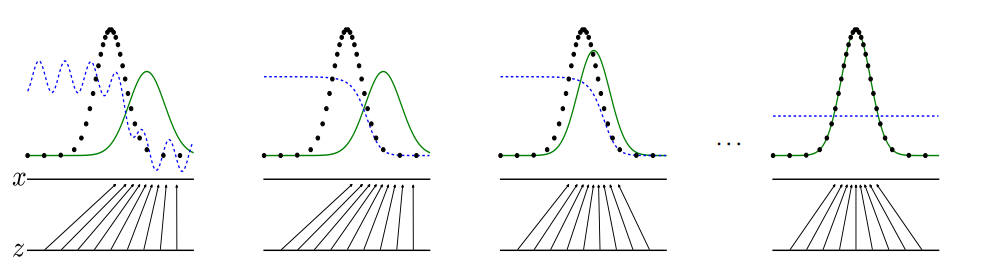

검정 점선 : 원본 data  
녹색선 : 생성자 분포  
파란 점선 : 판별자 분포

## 목적 함수

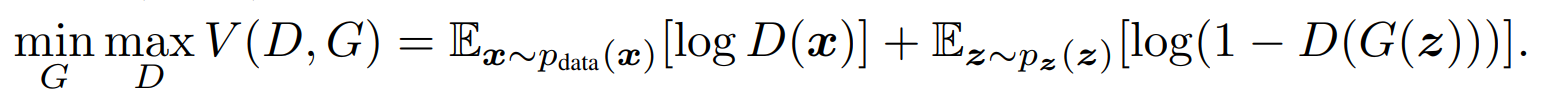

p_data(x) : 원본 데이터의 분포  
p_z(z) : 노이즈를 샘플링하는 분포  
G(z) : 임의의 z로 fake를 생성  
D(x) : x가 real에 가까울수록 1 fake일수록 0 값을 반환

## 이론

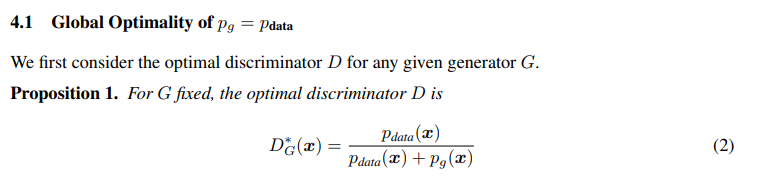

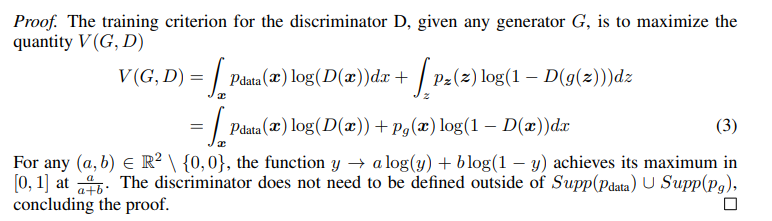

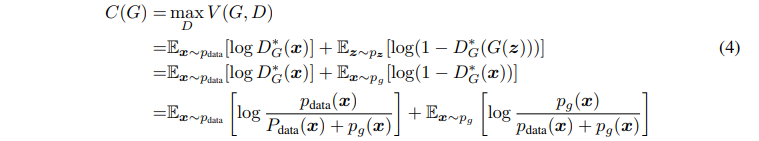

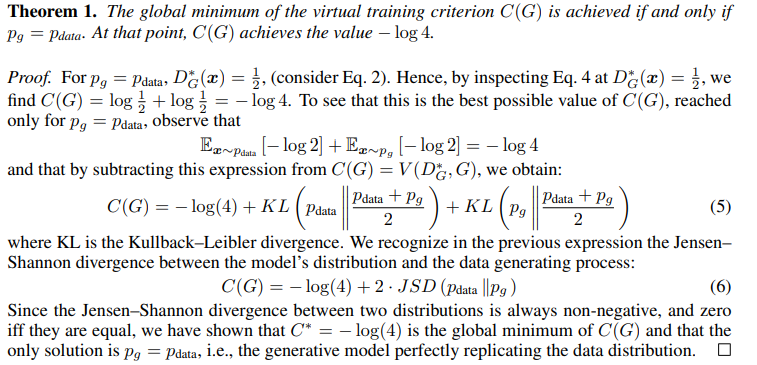

# 코드 실습 MNIST


In [ ]:
# 라이브러리
import torch
import torch.nn as nn

from torchvision import datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# 판별자 정의

img_size = 28*28*1
hidden_size1 = 256
hidden_size2 = 128

class Discriminator(nn.Module):
  def __init__(self):
      super(Discriminator, self).__init__()

      self.linear1 = nn.Linear(img_size, hidden_size1)
      self.linear2 = nn.Linear(hidden_size1, hidden_size2)
      self.linear3 = nn.Linear(hidden_size2, 1)
      self.leaky_relu = nn.LeakyReLU(0.2)
      self.sigmoid = nn.Sigmoid()

  def forward(self, x):
      x = self.leaky_relu(self.linear1(x))
      x = self.leaky_relu(self.linear2(x))
      x = self.linear3(x)
      x = self.sigmoid(x)
      return x

In [ ]:
# 생성자 정의

noise_size = 100

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.linear1 = nn.Linear(noise_size, hidden_size1)
        self.linear2 = nn.Linear(hidden_size1, hidden_size2)
        self.linear3 = nn.Linear(hidden_size2, img_size)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.linear3(x)
        x = self.tanh(x)
        return x

In [ ]:
# 데이터 불러오기

transforms_train = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

train_dataset = datasets.MNIST(root='./dataset', train = True,
                               download = True, transform=transforms_train)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, 
                                         shuffle = True, num_workers=4) # num_worker : 데이터 프로세싱에 할당되는 cpu 코어 수

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./dataset
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=28, interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )

In [ ]:
# 모델 학습 및 샘플링

generator = Generator()
discriminator = Discriminator()

#generator.cuda()
#discriminator.cuda()

# 손실함수 정의
adversarial_loss = nn.BCELoss()
#adversarial_loss.cuda()

lr = 0.0002
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5,0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5,0.999))

In [ ]:
n_epochs = 200

for epoch in range(n_epochs):
  for i,(images,_) in enumerate(dataloader):

    # 학습 레이블 생성
    real_label = torch.FloatTensor(images.size(0),1).fill_(1.0)
    fake_label = torch.FloatTensor(images.size(0),1).fill_(0.0)
    #real_label = torch.cuda.FloatTensor(images.size(0),1).fill_(1.0)
    #fake_label = torch.cuda.FloatTensor(images.size(0),1).fill_(0.0)

    # images를 flatten하게 reshape 하기
    real_images = images.reshape(images.size(0),-1)
    #real_images = images.reshape(images.size(0),-1).cuda()


    # ====== 생성자 학습 ======
    # 역전파 전 zero_grad로 grad 초기화
    optimizer_G.zero_grad() 
    # 노이즈 샘플링
    z = torch.normal(mean=0, std=1, size=(images.size(0), noise_size))
    #z = torch.normal(mean=0, std=1, size=(images.size(0), noise_size)).cuda()
    # 이미지 생성
    generated_imgs = generator(z)
    # 생성자 Loss 계산
    g_loss = adversarial_loss(discriminator(generated_imgs), real_label)
    # 생성자 업데이+트
    g_loss.backward()
    optimizer_G.step()

    # ====== 판별자 학습 ======
    # 역전파 전 zero_grad로 grad 초기화
    optimizer_D.zero_grad() 
    # 판별자 Loss 계산
    real_loss = adversarial_loss(discriminator(real_images), real_label)
    fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake_label)
    d_loss = (real_loss + fake_loss) / 2
    # 판별자 업데이트
    d_loss.backward()
    optimizer_D.step()
  print(f"[Epoch {epoch}/{n_epochs}] [D loss : {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}]")

[Epoch 0/200] [D loss : 0.437686] [G loss: 0.719297]
[Epoch 1/200] [D loss : 0.101200] [G loss: 2.029917]
[Epoch 2/200] [D loss : 0.070782] [G loss: 2.773603]
[Epoch 3/200] [D loss : 0.084335] [G loss: 3.073033]
[Epoch 4/200] [D loss : 0.093376] [G loss: 3.385362]
[Epoch 5/200] [D loss : 0.535193] [G loss: 5.790587]
[Epoch 6/200] [D loss : 0.060737] [G loss: 2.808009]
[Epoch 7/200] [D loss : 0.303739] [G loss: 5.057858]
[Epoch 8/200] [D loss : 0.073299] [G loss: 3.502429]
[Epoch 9/200] [D loss : 0.075426] [G loss: 3.030749]
[Epoch 10/200] [D loss : 0.207665] [G loss: 2.701031]
[Epoch 11/200] [D loss : 0.010483] [G loss: 6.287325]
[Epoch 12/200] [D loss : 0.060372] [G loss: 4.138822]
[Epoch 13/200] [D loss : 0.135765] [G loss: 5.021629]
[Epoch 14/200] [D loss : 0.036389] [G loss: 3.599381]
[Epoch 15/200] [D loss : 0.206983] [G loss: 1.604982]
[Epoch 16/200] [D loss : 0.031915] [G loss: 3.512633]
[Epoch 17/200] [D loss : 0.252779] [G loss: 6.558385]
[Epoch 18/200] [D loss : 0.088287] [G 

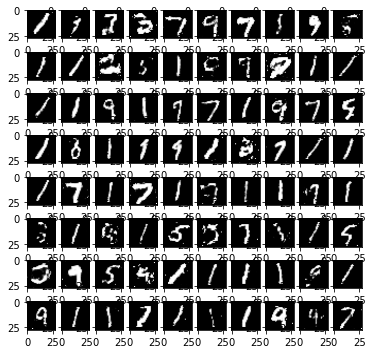

In [ ]:
z = torch.normal(mean=0, std=3, size=(80, noise_size))
#z = torch.normal(mean=0, std=3, size=(images.size(0), noise_size)).cuda()

generated_imgs = generator(z)
generated_imgs = generated_imgs.reshape((80,28,28))

rows,cols = 8,10
figure = plt.figure(figsize=(6,6))
for i in range(1,rows*cols+1):
  figure.add_subplot(rows,cols,i)
  plt.imshow(generated_imgs[i-1].cpu().detach().numpy(),cmap='gray')
plt.show()

# 코드 실습 Flowers102

In [ ]:
# 라이브러리

import torch
import torch.nn as nn

from torchvision import datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

# 데이터 불러오기

transforms_train = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
    ])

train_dataset = datasets.Flowers102(root='./dataset', download = True, transform=transforms_train)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128,  
                                         shuffle = True, num_workers=4) # num_worker : 데이터 프로세싱에 할당되는 cpu 코어 수

  0%|          | 0/344862509 [00:00<?, ?it/s]

Extracting dataset/flowers-102/102flowers.tgz to dataset/flowers-102


  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/14989 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## 데이터 살펴보기

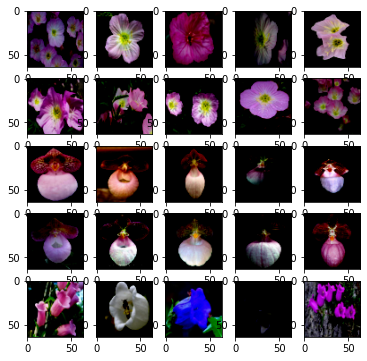

In [ ]:
rows,cols=5,5
figure = plt.figure(figsize=(6,6))
for i in range(1,26):
  figure.add_subplot(rows,cols,i)
  img,label = train_dataset[i-1]
  img = np.transpose(img, (1,2,0))
  plt.imshow(img)
plt.show()

## 모델 정의

In [ ]:
# 생성자 정의

noise_size = 100

class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.lin1 = nn.Linear(noise_size,16*16*64)
    self.lkrl = nn.LeakyReLU(0.2)
    self.con1 = nn.ConvTranspose2d(64,32,4,2,1)
    self.con2 = nn.ConvTranspose2d(32,3,4,2,1)
    self.tanh = nn.Tanh()
    
  def forward(self, z):
    x = self.lkrl(self.lin1(z))
    x = x.reshape((-1,64,16,16))
    x = self.lkrl(self.con1(x))
    x = self.tanh(self.con2(x))
    return x

In [ ]:
# 판별자 정의

class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.con1 = nn.Conv2d(3,16,3)
    self.con2 = nn.Conv2d(16,32,4)
    self.con3 = nn.Conv2d(32,64,3)
    self.pool = nn.MaxPool2d(2,2)
    self.lkrl = nn.LeakyReLU(0.2)
    self.sigm = nn.Sigmoid()
    self.lin1 = nn.Linear(64*6*6,512)
    self.lin2 = nn.Linear(512,1)

  def forward(self, img):
    x = self.pool(self.lkrl(self.con1(img)))
    x = self.pool(self.lkrl(self.con2(x)))
    x = self.pool(self.lkrl(self.con3(x)))
    x = x.reshape((-1,64*6*6))
    x = self.lkrl(self.lin1(x))
    x = self.sigm(self.lin2(x))
    return x

## 모델 학습

In [ ]:
# 모델 학습 및 샘플링

generator = Generator()
discriminator = Discriminator()

generator.cuda()
discriminator.cuda()

# 손실함수 정의
adversarial_loss = nn.BCELoss()
adversarial_loss.cuda()

lr = 0.0002
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5,0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5,0.999))

import time

n_epochs = 200
start_time = time.time()

for epoch in range(n_epochs):
  for i,(imgs,_) in enumerate(dataloader):
    real = torch.cuda.FloatTensor(imgs.size(0),1).fill_(1.0)
    fake = torch.cuda.FloatTensor(imgs.size(0),1).fill_(0.0)
    real_imgs = imgs.cuda()

    # ====== 생성자 학습 ======
    # 역전파 전 zero_grad로 grad 초기화
    optimizer_G.zero_grad() 
    # 노이즈 샘플링
    z = torch.normal(mean=0, std=1, size=(imgs.shape[0], noise_size)).cuda()
    # 이미지 생성
    generated_imgs = generator(z)
    # 생성자 Loss 계산
    g_loss = adversarial_loss(discriminator(generated_imgs), real)
    # 생성자 업데이트
    g_loss.backward()
    optimizer_G.step()

    # ====== 판별자 학습 ======
    # 역전파 전 zero_grad로 grad 초기화
    optimizer_D.zero_grad() 
    # 판별자 Loss 계산
    real_loss = adversarial_loss(discriminator(real_imgs), real)
    fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)
    d_loss = (real_loss + fake_loss) / 2
    # 판별자 업데이트
    d_loss.backward()
    optimizer_D.step()

  print(f"[Epoch {epoch}/{n_epochs}] [D loss : {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")

In [ ]:
#z = torch.normal(mean=0, std=3, size=(80, noise_size))
z = torch.normal(mean=0, std=3, size=(80, noise_size)).cuda()
generated_imgs = generator(z)
rows,cols = 8,10
figure = plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
  figure.add_subplot(rows,cols,i)
  plt.imshow(generated_imgs[i-1].cpu().detach().numpy().transpose((1,2,0)))
plt.show()

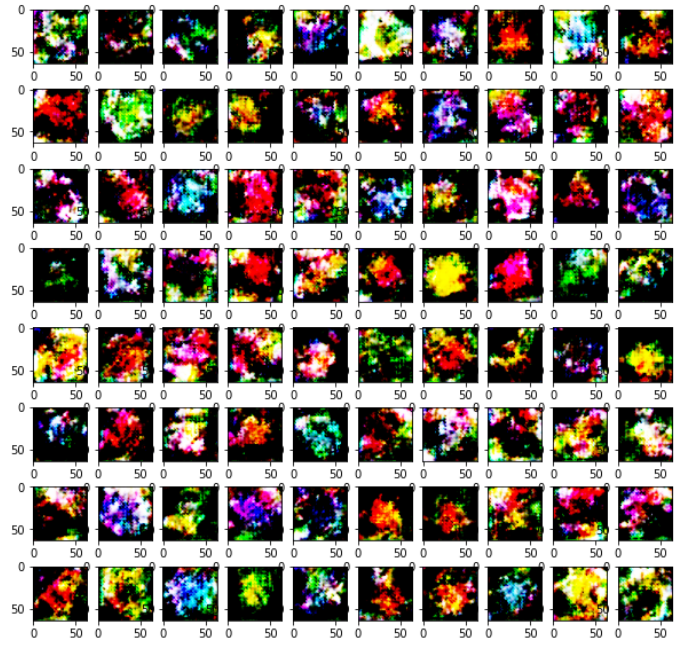

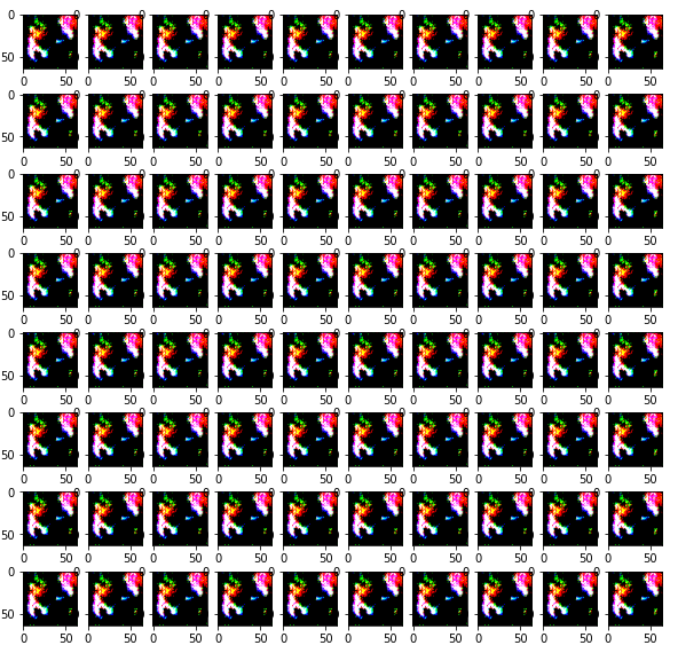

판별자와 생성자가 서로 상호작용을 하며 같이 학습해야 하는데 한쪽이 너무 학습이 잘되서 mode collapse가 발생합니다. 

# Oxford 실습

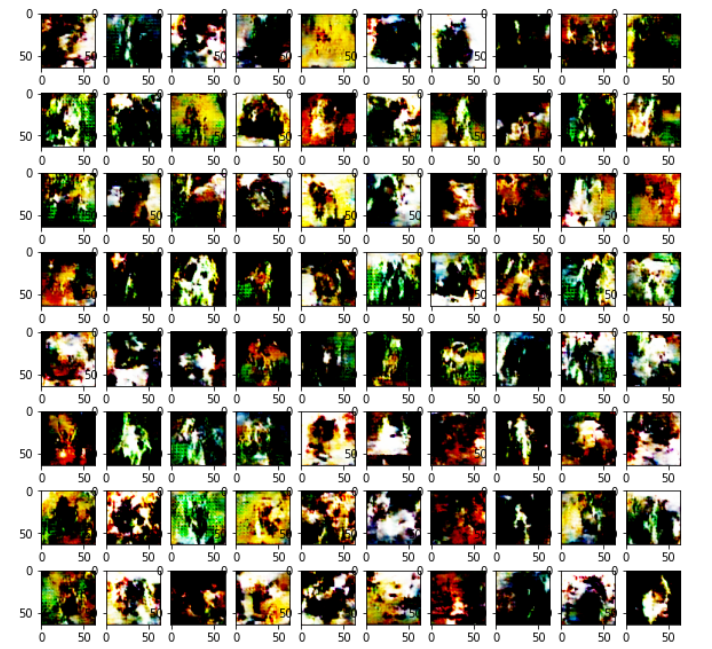